In [1]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt

np.random.seed(0)

#Загрузка данных

In [2]:
def loading_data(paths):
    columns = ["Цена за кв.м", "Регион", "Общая площадь", "Форма проведения", "Жителей в округе",
               "Коммерческих объектов", "Жителей h3", "Имущество", "Расстояние до почты", "Этаж"]
    numeric_features = ["Жителей", "Коммерческих объектов", "Общая площадь", "Расстояние до почты"]
    df = pd.DataFrame()
    if type(paths) == list:
        for path in paths:
            df = pd.concat((df, pd.read_excel(path)[columns]), axis=0)
    else:
        df = pd.read_excel(paths)[columns]
        
    df["Жителей"] = df[["Жителей h3", "Жителей в округе"]].max(axis=1, numeric_only=True)
    df.drop(columns=['Жителей h3', 'Жителей в округе'], axis=1, inplace=True)
    # если жителей в округе 2к значит, точно есть почтовое отделение просто его не смогли найти, не будем учитывать его
    df.loc[((df['Расстояние до почты'].isnull()) & (df["Жителей"] >= 2000)), 'Расстояние до почты'] = 100
    df['Расстояние до почты'].replace(np.nan, 5000, inplace=True)
    df['Коммерческих объектов'].replace(np.nan, 0, inplace=True)
    df['Этаж'].replace(np.nan, 0, inplace=True)
    df['Жителей'].replace('', np.nan, inplace=True)
    df.loc[df["Жителей"] == 'None', "Жителей"] = np.nan
    
    df.dropna(subset=['Жителей'], inplace=True)
    for name in numeric_features:
        df[name].replace(np.nan, 0, inplace=True)
    df["Этаж"].replace(np.nan, 0, inplace=True)
    df = df.dropna()

    return df
df = loading_data(['../torgi/output_archive.xlsx', '../torgi/output.xlsx'])
print(pd.isnull(df).any())

Цена за кв.м             False
Регион                   False
Общая площадь            False
Форма проведения         False
Коммерческих объектов    False
Имущество                False
Расстояние до почты      False
Этаж                     False
Жителей                  False
dtype: bool


<AxesSubplot:title={'center':'Цена за кв.м'}, xlabel='Регион'>

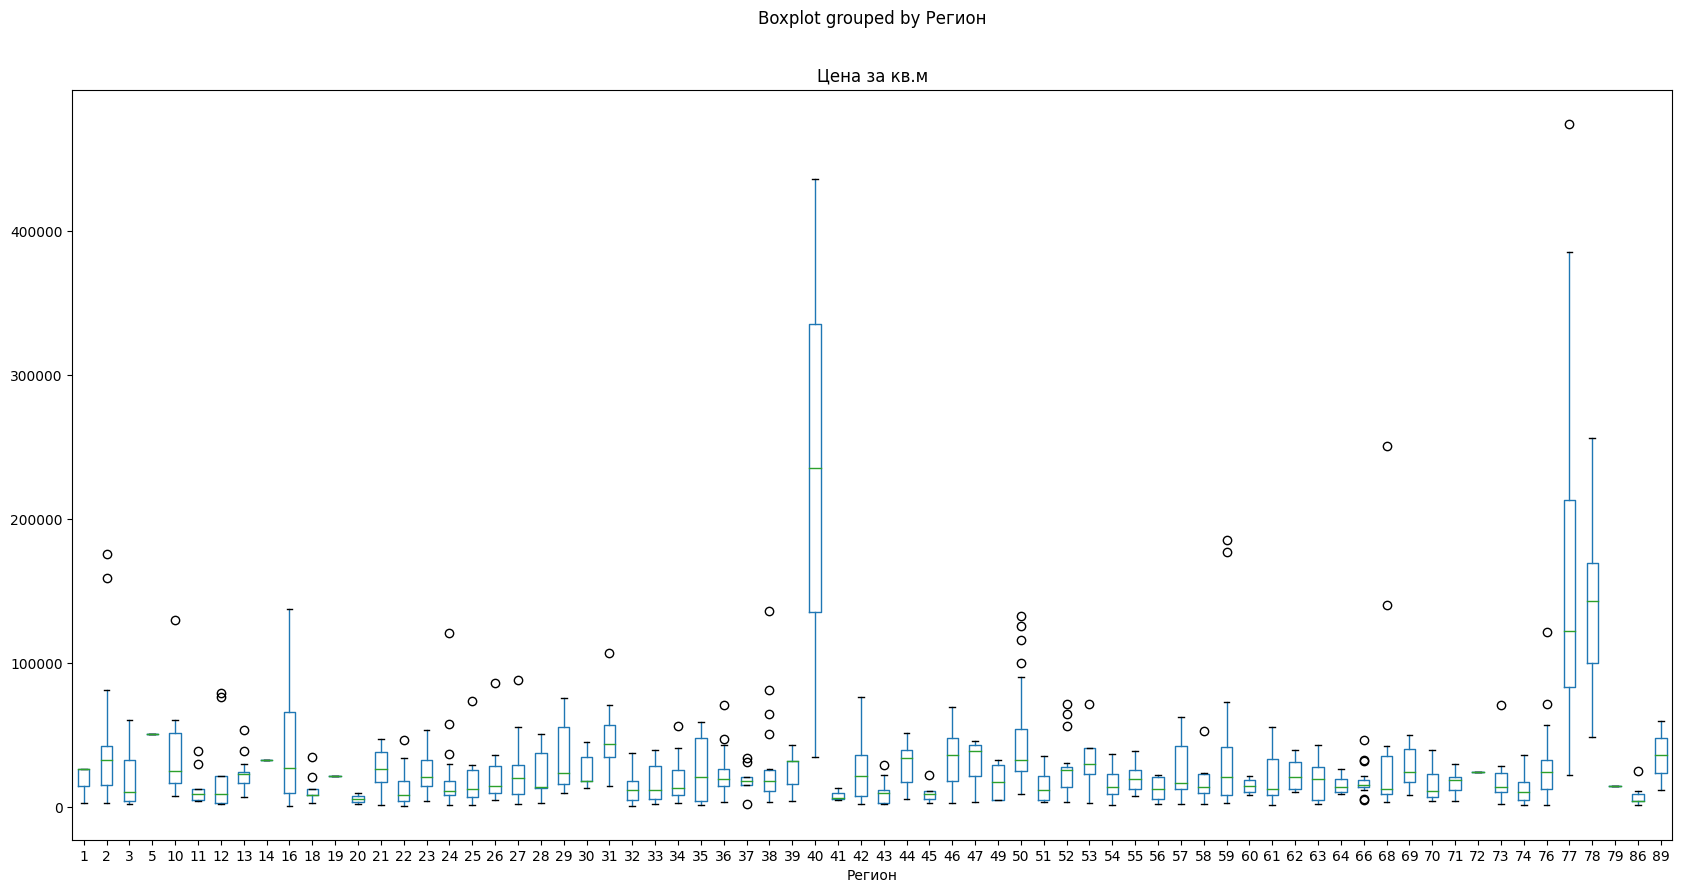

In [3]:
target = "Цена за кв.м"
numeric_features = ["Жителей", "Коммерческих объектов", "Общая площадь", "Расстояние до почты"]
categorical_features = ["Регион", "Форма проведения", "Имущество", "Этаж"]
columns = [target] +numeric_features + categorical_features

# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', 10)

#смотрим в каких регионах сильный разброс цены за кв.м
df.boxplot(by ='Регион', column =[target], grid = False, figsize=(20,10))

In [4]:
#убираем их из обучения, так как для них нужно обучать свою модель
df = df[~df["Регион"].isin(set([78,77,40]))]

<AxesSubplot:>

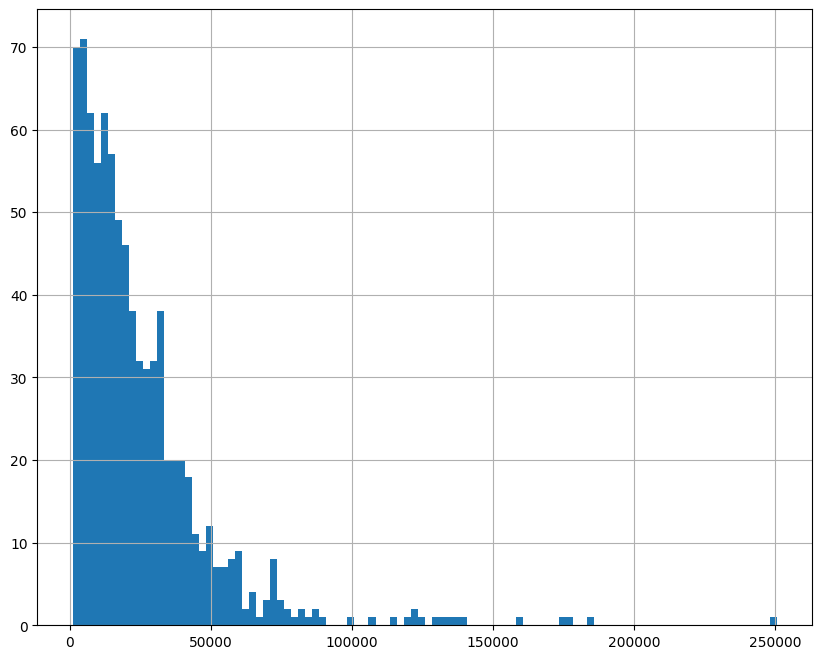

In [5]:
df.corrwith(df[target])
df[target].hist(bins=100, figsize=(10,8))

In [6]:
#удаляем выбросы
def remove_row_emissions(data, row_name):
    print("remove emissions ", row_name)
    lower_bound = data[row_name].quantile(q=0.025)
    upper_bound = data[row_name].quantile(q=0.975)
    #print(data)
    data[(data[row_name] < lower_bound) | (data[row_name] > upper_bound)] = np.nan
    data.dropna(subset=[row_name], inplace=True)

remove_row_emissions(df, "Цена за кв.м")
remove_row_emissions(df, "Общая площадь")

remove emissions  Цена за кв.м
remove emissions  Общая площадь


In [23]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy='median')), ("scaler", MinMaxScaler())]
)
#SimpleImputer(strategy='constant', fill_value=1)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", DecisionTreeRegressor(max_depth=4))]
)
#Ridge(alpha=10)
    #model train score: 0.367
    #model test score: 0.300
    #MAE: 10674.231

#KNeighborsRegressor(8)
    #model train score: 0.405
    #model test score: 0.305
    #MAE: 10418.642
#DecisionTreeRegressor(max_depth=4)
    #model train score: 0.435
    #model test score: 0.121
    #MAE: 11433.182

In [24]:
#тренируем модель
y = df["Цена за кв.м"].values
X = df.drop("Цена за кв.м", axis=1)

df_test = loading_data('../torgi/output_test.xlsx')
df_test = df_test[~df_test["Регион"].isin(set([78,77,40]))]

y_test = df_test["Цена за кв.м"].values
X_test = df_test.drop("Цена за кв.м", axis=1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Жителей',
                                                   'Коммерческих объектов',
                                                   'Общая площадь',
                                                   'Расстояние до почты']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Регион', 'Форма проведения',
                                                   'Имущество', 'Этаж'])])),
                ('regressor', DecisionTreeRegressor(max_depth=4))])

In [25]:
print("model train score: %.3f" % clf.score(X, y))
print("model test score: %.3f" % clf.score(X_test, y_test))
print("MAE: %.3f" % mean_absolute_error(y_test, clf.predict(X_test)))

model train score: 0.399
model test score: 0.482
MAE: 11182.923


In [22]:
#смотрим результаты
df2 = df.copy() 
df2['predicted'] = clf.predict(df2[numeric_features+categorical_features])
df2

,Цена за кв.м,Регион,Общая площадь,Форма проведения,Коммерческих объектов,Имущество,Расстояние до почты,Этаж,Жителей,predicted
0,26729.678639,1.0,52.9,EA,118.0,М,100.0,1.0,4001.0,25081.462257
2,3182.651191,2.0,491.1,EA,3.0,М,1800.0,0.0,336.0,27842.185283
4,11831.988016,2.0,283.7,EA,12.0,Д,800.0,0.0,4359.0,33390.689027
5,13431.731104,2.0,574.2,PP,44.0,М,200.0,1.0,3892.0,10734.016221
6,18726.591760,2.0,347.1,EA,23.0,М,500.0,0.0,2049.0,27938.282185
...,...,...,...,...,...,...,...,...,...,...
482,8186.728395,86.0,129.6,EA,32.0,М,600.0,1.0,2379.0,12562.979923
483,8894.308943,86.0,123.0,EA,13.0,М,400.0,1.0,6732.0,14970.398070
484,11300.000000,86.0,579.5,PP,23.0,М,500.0,1.0,1955.0,10662.629343
485,25256.979695,86.0,315.2,EA,40.0,М,300.0,0.0,3091.0,9973.231736


In [26]:
%pip install -U lightautoml[nlp] -qqqq

Note: you may need to restart the kernel to use updated packages.
